In [1]:
# Load in libraries
# Data loading / manipulation
import pathlib
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Plotting
import cmocean
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Statistics
import astropy.stats
import scipy.stats
import scikit_posthocs
import traja

# Adjust plotting styles
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'font.size': 20})
plt.rcParams['axes.linewidth'] = 1.1
plt.rcParams['xtick.major.width'] = 1.1
plt.rcParams['ytick.major.width'] = 1.1
BXPLT_PROPS = {
    'boxprops':{'edgecolor':'black', 'linewidth': 1},
    'medianprops':{'color':'black', 'linewidth': 1},
    'whiskerprops':{'color':'black', 'linewidth': 1},
    'capprops':{'color':'black', 'linewidth': 1}
}  # sns

In [2]:
data_root = pathlib.Path("datasets")
experiment_run_date = "2023-12-03"
nbins = 24  # Data binned by 'nbins' many bins of angles around 360 degrees to the dancer
max_antenna_angle = 90  # Maximum angle (degrees) of the antenna relative to the nestmate's midline / body axis

my_colors = ["#2E22EA","#9E3DFB","#F86BE2","#FCCE7B","#C4E416","#4BBA0F","#447D87","#2C24E9"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", my_colors)

# Nestmate angles (Fig. 1)

### Histogram: Batchelet's straightness index (1B)

Phases (total): 59
Bees (total): 47


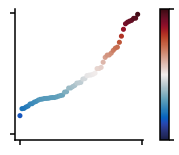

In [3]:
straightness_df = pd.read_csv(data_root / "orientation_straightness.csv").sort_values(by=["straightness"]).reset_index()
print("Phases (total):", straightness_df.index.shape[0])
print("Bees (total):", straightness_df[~straightness_df["bee_id"].str.contains("_")].shape[0])

plt.figure(figsize=(2.2, 1.7))
plt.scatter(straightness_df.index, straightness_df["straightness"], s=7, c=straightness_df["straightness"], cmap=cmocean.cm.balance, norm=plt.Normalize(0, 1),)
ax = plt.gca()
plt.ylim(-0.05)
plt.yticks([0, 1])
ax.set_yticklabels(["", ""])
plt.xlim(-2.5, 60.5)
plt.xticks([0, 60])
ax.set_xticklabels(["", ""])
ax.set_xlabel("")
ax.spines[['top', 'right']].set_visible(False)
cbar = plt.colorbar(pad=0.1, aspect=14)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["", ""])
plt.show()

### Polar plots: stable and changing body axes angles (1C)

In [4]:
# Uncomment to generate and export (x,y) coordinates of nestmates mean body axis orientation (if not already done)
# orientations_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}-orientations.csv"))[0])
# for name, group in orientations_df.groupby("bee_id"):
#     time_range = (group.index - group.index[0]).values
#     group["x"] = np.cos(group["mean_orientation"]) * time_range
#     group["y"] = np.sin(group["mean_orientation"]) * time_range
#     group[["x", "y"]].to_csv(f"{data_root / 'nestmates_coordinates'}/{name}-coords.csv", index=False)
#     plt.plot(group["x"], group["y"])
# plt.gca().set_aspect('equal', adjustable='box')

straightness_df = pd.read_csv(data_root / "orientation_straightness.csv").sort_values(by=["straightness"]).reset_index()
# Add category of stable versus changing
straightness_df["category"] = straightness_df.apply(lambda bee: "Changing" if bee["straightness"] < 0.5 else "Stable", axis=1)
# Load coordinates and smooth using Savitzky-Golay filter
coords_dfs = {}
for coords in list((data_root / 'nestmates_coordinates').glob("*.csv")):
    bee_id = coords.stem.split("-")[0]
    df = traja.read_file(str(coords))
    coords_dfs[bee_id] = df
df = pd.concat(coords_dfs).reset_index().drop(columns=["level_1"]).rename(columns={"level_0": "bee_id"})
smoothed_df = df.groupby("bee_id", group_keys=False).apply(lambda bee_df: traja.smooth_sg(bee_df, w=31) if bee_df.shape[0] > 31 else bee_df)
smoothed_df = smoothed_df.join(straightness_df.set_index("bee_id"), on="bee_id") 
smoothed_df.head()

,bee_id,x,y,index,straightness,sinuosity,category
0,n36,-0.462367,-0.201733,30.0,0.708068,32.108894,Stable
1,n36,-0.511980,0.856134,30.0,0.708068,32.108894,Stable
2,n36,-0.611495,1.894183,30.0,0.708068,32.108894,Stable
3,n36,-0.758592,2.913269,30.0,0.708068,32.108894,Stable
4,n36,-0.950952,3.914249,30.0,0.708068,32.108894,Stable


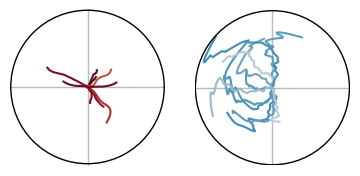

In [5]:
# Plot all of stable trajectories and a subsample of the changing trajectories
fig, axs = plt.subplots(1, 2, figsize=(4, 2.7))
stable_df = smoothed_df[(smoothed_df["category"] == "Stable") & (smoothed_df["straightness"] > 0.75)]
for bee_id, group in stable_df.groupby("bee_id"):
    frames = group.shape[0]
    axs[0].plot(group["x"], group["y"], c=cmocean.cm.balance(group["straightness"].iloc[0]))
max_time_stable = 100  # 0.5 seconds
circ = plt.Circle((0.0, 0.0), max_time_stable, fill=False, zorder=2)
axs[0].set_xlim(-max_time_stable-1, max_time_stable+1)
axs[0].set_ylim(-max_time_stable-3, max_time_stable+1)
axs[0].add_artist(circ)
axs[0].axhline(0, color="#BCBCBC", linewidth=1, zorder=0)
axs[0].axvline(0, color="#BCBCBC", linewidth=1, zorder=0)

changing_df = smoothed_df[smoothed_df["category"] == "Changing"]
changing_df = changing_df[changing_df["bee_id"].isin(changing_df["bee_id"].sample(14))]
for bee_id, group in changing_df.groupby("bee_id"):
    frames = group.shape[0]
    axs[1].plot(group["x"], group["y"], c=cmocean.cm.balance(group["straightness"].iloc[0]))
max_time_changing = 400  # 2 seconds
circ = plt.Circle((0.0, 0.0), max_time_changing, fill=False, zorder=2)
axs[1].set_xlim(-max_time_changing-2, max_time_changing+3)
axs[1].set_ylim(-max_time_changing-3, max_time_changing+3)
axs[1].add_artist(circ)
axs[1].axhline(0, color="#BCBCBC", linewidth=1, zorder=0)
axs[1].axvline(0, color="#BCBCBC", linewidth=1, zorder=0)

axs[0].set_aspect(1)
axs[0].axis("off")
axs[1].set_aspect(1)
axs[1].axis("off")
plt.tight_layout()

In [6]:
print(stable_df["bee_id"].unique().shape[0], "stable plotted.")
print(changing_df["bee_id"].unique().shape[0], "changing plotted.")
smoothed_df.groupby("category").agg({"bee_id": "nunique"})

10 stable plotted.
11 changing plotted.


,bee_id
category,
Changing,37
Stable,22


# Antennae angles (Figs. 1, S2)

### Ribbon plot: left and right antennae angles (1E)

Uses the angle defined by the full length of antenna if available, and if not visible, then the angle defined by mid-length or bend.

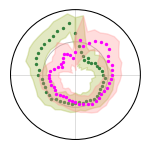

In [7]:
tmp_bin_size = 48
binned_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}-{tmp_bin_size}-binned.csv"))[0])
binned_df = binned_df.sort_values(by="remapped_bin_angle_to_dancer_deg")

plt.figure(figsize=(1.7, 1.7))
ax = plt.subplot(projection='polar')
ribbon_low = binned_df["l_antenna_mean_deg"] - binned_df["l_antenna_std_deg"]
ribbon_high = binned_df["l_antenna_mean_deg"] + binned_df["l_antenna_std_deg"]
remapped = np.concatenate((binned_df["remapped_bin_angle_to_dancer_rad"], [np.radians(360)]))
ribbon_low = np.concatenate((ribbon_low, [ribbon_low.iloc[0]]))  # To fix wrapping
ribbon_high = np.concatenate((ribbon_high, [ribbon_high.iloc[0]]))
plt.fill_between(remapped, y1=ribbon_low, y2=ribbon_high, color="#A0B535", alpha=0.3) 
plt.scatter(binned_df["remapped_bin_angle_to_dancer_rad"], binned_df["l_antenna_mean_deg"], s=2, c="#33813E")

ribbon_low = np.abs(binned_df["r_antenna_mean_deg"]) - binned_df["r_antenna_std_deg"]
ribbon_high = np.abs(binned_df["r_antenna_mean_deg"]) + binned_df["r_antenna_std_deg"]
ribbon_low = np.concatenate((ribbon_low, [ribbon_low.iloc[-1]])) # To fix wrapping
ribbon_high = np.concatenate((ribbon_high, [ribbon_high.iloc[0]]))
remapped = np.concatenate((binned_df["remapped_bin_angle_to_dancer_rad"], [np.radians(360)]))
plt.fill_between(remapped, y1=ribbon_low, y2=ribbon_high, color="#FF8F8F", alpha=0.3) 
plt.scatter(binned_df["remapped_bin_angle_to_dancer_rad"], np.abs(binned_df["r_antenna_mean_deg"]), s=2, c="#FB00FF")

ax.set_ylim([0, 90])
ax.set_yticks([0, 45, 90])
ax.set_yticklabels(["", "", ""])
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(180)
plt.thetagrids([0, 90, 180, -90])
ax.set_xticklabels(["", "", "", ""])
ax.spines['polar'].set_visible(False)
ax.grid(False)
circle = plt.Circle((0.0, 0.0), 90, transform=ax.transData._b, fill=False, linewidth=1.5, zorder=2)
ax.add_artist(circle)
lw = 0.7
circle = plt.Circle((0.0, 0.0), 45, transform=ax.transData._b, fill=False, linewidth=0.7, color="#BCBCBC", zorder=-1)
ax.add_artist(circle)

ax.axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
plt.show()

### Ribbon plot: left and right antennae angles using full-length (S2C top)

Uses the angles defined by the full length of the antennae only

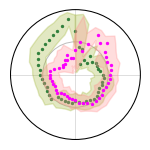

In [8]:
tmp_bin_size = 48
binned_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}-full_antenna_len-{tmp_bin_size}-binned.csv"))[0])
binned_df = binned_df.sort_values(by="remapped_bin_angle_to_dancer_deg")

plt.figure(figsize=(1.7, 1.7))
ax = plt.subplot(projection='polar')
ribbon_low = binned_df["l_antenna_mean_deg"] - binned_df["l_antenna_std_deg"]
ribbon_high = binned_df["l_antenna_mean_deg"] + binned_df["l_antenna_std_deg"]
remapped = np.concatenate((binned_df["remapped_bin_angle_to_dancer_rad"], [np.radians(360)]))
ribbon_low = np.concatenate((ribbon_low, [ribbon_low.iloc[0]]))  # To fix wrapping
ribbon_high = np.concatenate((ribbon_high, [ribbon_high.iloc[0]]))
plt.fill_between(remapped, y1=ribbon_low, y2=ribbon_high, color="#A0B535", alpha=0.3) 
plt.scatter(binned_df["remapped_bin_angle_to_dancer_rad"], binned_df["l_antenna_mean_deg"], s=2, c="#33813E")

ribbon_low = np.abs(binned_df["r_antenna_mean_deg"]) - binned_df["r_antenna_std_deg"]
ribbon_high = np.abs(binned_df["r_antenna_mean_deg"]) + binned_df["r_antenna_std_deg"]
ribbon_low = np.concatenate((ribbon_low, [ribbon_low.iloc[-1]])) # To fix wrapping
ribbon_high = np.concatenate((ribbon_high, [ribbon_high.iloc[0]]))
remapped = np.concatenate((binned_df["remapped_bin_angle_to_dancer_rad"], [np.radians(360)]))
plt.fill_between(remapped, y1=ribbon_low, y2=ribbon_high, color="#FF8F8F", alpha=0.3) 
plt.scatter(binned_df["remapped_bin_angle_to_dancer_rad"], np.abs(binned_df["r_antenna_mean_deg"]), s=2, c="#FB00FF")

ax.set_ylim([0, 90])
ax.set_yticks([0, 45, 90])
ax.set_yticklabels(["", "", ""])
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(180)
plt.thetagrids([0, 90, 180, -90])
ax.set_xticklabels(["", "", "", ""])
ax.spines['polar'].set_visible(False)
ax.grid(False)
circle = plt.Circle((0.0, 0.0), 90, transform=ax.transData._b, fill=False, linewidth=1.5, zorder=2)
ax.add_artist(circle)
lw = 0.7
circle = plt.Circle((0.0, 0.0), 45, transform=ax.transData._b, fill=False, linewidth=0.7, color="#BCBCBC", zorder=-1)
ax.add_artist(circle)

ax.axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
plt.show()

### Ribbon plot: left and right antennae angles using mid-length (S2C bottom)

Uses the angles defined by the mid-length of the antennae only

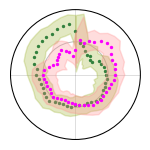

In [9]:
tmp_bin_size = 48
binned_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}-mid_antenna_len-{tmp_bin_size}-binned.csv"))[0])
binned_df = binned_df.sort_values(by="remapped_bin_angle_to_dancer_deg")

plt.figure(figsize=(1.7, 1.7))
ax = plt.subplot(projection='polar')
ribbon_low = binned_df["l_antenna_mean_deg"] - binned_df["l_antenna_std_deg"]
ribbon_high = binned_df["l_antenna_mean_deg"] + binned_df["l_antenna_std_deg"]
remapped = np.concatenate((binned_df["remapped_bin_angle_to_dancer_rad"], [np.radians(360)]))
ribbon_low = np.concatenate((ribbon_low, [ribbon_low.iloc[0]]))  # To fix wrapping
ribbon_high = np.concatenate((ribbon_high, [ribbon_high.iloc[0]]))
plt.fill_between(remapped, y1=ribbon_low, y2=ribbon_high, color="#A0B535", alpha=0.3) 
plt.scatter(binned_df["remapped_bin_angle_to_dancer_rad"], binned_df["l_antenna_mean_deg"], s=2, c="#33813E")

ribbon_low = np.abs(binned_df["r_antenna_mean_deg"]) - binned_df["r_antenna_std_deg"]
ribbon_high = np.abs(binned_df["r_antenna_mean_deg"]) + binned_df["r_antenna_std_deg"]
ribbon_low = np.concatenate((ribbon_low, [ribbon_low.iloc[-1]])) # To fix wrapping
ribbon_high = np.concatenate((ribbon_high, [ribbon_high.iloc[0]]))
remapped = np.concatenate((binned_df["remapped_bin_angle_to_dancer_rad"], [np.radians(360)]))
plt.fill_between(remapped, y1=ribbon_low, y2=ribbon_high, color="#FF8F8F", alpha=0.3) 
plt.scatter(binned_df["remapped_bin_angle_to_dancer_rad"], np.abs(binned_df["r_antenna_mean_deg"]), s=2, c="#FB00FF")

ax.set_ylim([0, 90])
ax.set_yticks([0, 45, 90])
ax.set_yticklabels(["", "", ""])
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(180)
plt.thetagrids([0, 90, 180, -90])
ax.set_xticklabels(["", "", "", ""])
ax.spines['polar'].set_visible(False)
ax.grid(False)
circle = plt.Circle((0.0, 0.0), 90, transform=ax.transData._b, fill=False, linewidth=1.5, zorder=2)
ax.add_artist(circle)
lw = 0.7
circle = plt.Circle((0.0, 0.0), 45, transform=ax.transData._b, fill=False, linewidth=0.7, color="#BCBCBC", zorder=-1)
ax.add_artist(circle)

ax.axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
plt.show()

### Ribbon plot: antennae midpoint versus angle to dancer (1F)

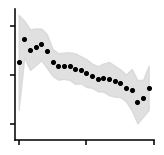

In [10]:
# Load data binned by angle to dancer
binned_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}-{nbins}-binned.csv"))[0])
binned_df = binned_df.sort_values(by="remapped_bin_angle_to_dancer_deg")

plt.figure(figsize=(1.8, 1.7))
ribbon_low = binned_df["midpt_mean_deg"] - binned_df["midpt_std_deg"]
ribbon_high = binned_df["midpt_mean_deg"] + binned_df["midpt_std_deg"]
plt.fill_between(binned_df["remapped_bin_angle_to_dancer_deg"], y1=ribbon_low, y2=ribbon_high, color="lightgray", alpha=0.7) 
plt.scatter(binned_df["remapped_bin_angle_to_dancer_deg"], binned_df["midpt_mean_deg"], s=7, c="black")
ax = plt.gca()
ax.set_yticks([-30, 0, 30])
ax.set_yticklabels(["", "", ""])
ax.set_ylim(-40, 40)
ax.set_xticks([0, 180, 360])
ax.set_xticklabels(["", "", ""])
ax.set_xlim(-10, 360)
ax.set_xlabel("")
ax.spines[['top', 'right']].set_visible(False)

In [11]:
# Circular correlation coefficient
features_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}-features.csv"))[0])
corr = astropy.stats.circcorrcoef(features_df["angle_to_dancer_rad"], features_df["antenna_midpoint_rad"])
print("Circ correlation coefficient:", np.round(corr, 2))

Circ correlation coefficient: -0.56


### Scatter plot: mean left versus right antenne angles using full-length (S2D top)

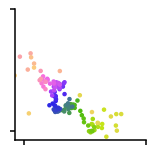

In [12]:
tmp_bin_size = 120
binned_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}-full_antenna_len-{tmp_bin_size}-binned.csv"))[0])
binned_df = binned_df.sort_values(by="remapped_bin_angle_to_dancer_deg")

plt.figure(figsize=(1.8, 1.7))
plt.scatter(binned_df["l_antenna_mean_deg"], binned_df["r_antenna_mean_deg"], s=5, c=binned_df["bin_angle_to_dancer_deg"], cmap=cmap, norm=plt.Normalize(-180,180))
plt.ylim(None, -15)
plt.xlim(15)
plt.xticks([20, 90])
plt.yticks([-20, -90])
ax = plt.gca()
ax.set_aspect("equal")
ax.invert_yaxis()
ax.set_yticklabels(["", ""])
ax.set_xticklabels(["", ""])
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("")
plt.ylabel("")
plt.show()

### Scatter plot: mean left versus right antenne angles using mid-length (S2D bottom)

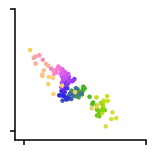

In [13]:
tmp_bin_size = 120
binned_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}-mid_antenna_len-{tmp_bin_size}-binned.csv"))[0])
binned_df = binned_df.sort_values(by="remapped_bin_angle_to_dancer_deg")

plt.figure(figsize=(1.8, 1.7))
norm=plt.Normalize(-180,180)
plt.scatter(binned_df["l_antenna_mean_deg"], binned_df["r_antenna_mean_deg"], s=5, c=binned_df["bin_angle_to_dancer_deg"], cmap=cmap, norm=plt.Normalize(-180,180))
plt.ylim(None, -15)
plt.xlim(15)
plt.xticks([20, 90])
plt.yticks([-20, -90])
ax = plt.gca()
ax.set_aspect("equal")
ax.invert_yaxis()
ax.set_yticklabels(["", ""])
ax.set_xticklabels(["", ""])
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("")
plt.ylabel("")
plt.show()

### Colourmap

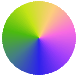

In [14]:
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(40, 70, 1)
values = azimuths * np.ones((30, 361))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), dpi=20)
plt.grid(False)
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmap)
ax.set_theta_zero_location("S")
ax.set_yticks([])
ax.set_xticks([])
plt.axis("off")
plt.show()

### Polarplot: sample left and right antenna angle

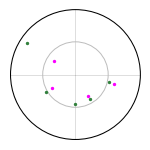

In [15]:
example_data = {
  "angle_to_dancer": np.radians([57, 121, 180, -150, -103]),
  "left_antenna": [80, 47, 40, 39, 48],
  "right_antenna": np.abs([-35, -37, np.nan, -34, -55])
}

plt.figure(figsize=(1.7, 1.7))
ax = plt.subplot(projection='polar')
plt.scatter(example_data["angle_to_dancer"], example_data["left_antenna"], s=2, c="#33813E")
plt.scatter(example_data["angle_to_dancer"], example_data["right_antenna"], s=2, c="#FB00FF")

ax.set_ylim([0, 90])
ax.set_yticks([0, 45, 90])
ax.set_yticklabels(["", "", ""])
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(180)
plt.thetagrids([0, 90, 180, -90])
ax.set_xticklabels(["", "", "", ""])
ax.spines['polar'].set_visible(False)
ax.grid(False)

lw = 0.7
circle = plt.Circle((0.0, 0.0), 90, transform=ax.transData._b, fill=False, linewidth=1.5, zorder=2)
ax.add_artist(circle)
circle = plt.Circle((0.0, 0.0), 45, transform=ax.transData._b, fill=False, linewidth=lw, color="#BCBCBC", zorder=-1)
ax.add_artist(circle)

ax.axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
plt.show()

# Vector assimilation: angular error (Figs. 4, S4)

### Boxplot: antennal method (4A)

In [16]:
def remove_outliers(df, show_hist=False):
    for i in df["method"].unique():
        method_df = df[df["method"] == i]
        angles_deg = np.degrees(method_df["mean_rad"])
        zscores = np.abs(scipy.stats.zscore(np.abs(angles_deg)))
        outliers = np.where(np.abs(zscores) > 2.9)[0]  # 3-sigma rule
        print("Dropped", len(outliers), "outliers",  method_df.iloc[outliers]["bee_id"].values,"for method", i)
        df = df.drop(df[(df["method"] == i) & df["bee_id"].isin(method_df.iloc[outliers]["bee_id"].values)].index)
        zscores = scipy.stats.zscore(df[df["method"] == i]["abs_mean_deg"])
        if show_hist:
            plt.hist(np.abs(angles_deg), alpha=0.6)
            plt.show()
    return df
    
methods = [
    "left_only",
    "right_only",
    "midpoint",
    "no_antennae",
    "single_antennae",
]
dfs = {}
for method in methods:
    method_csv = list((data_root).glob(f"{experiment_run_date}*{method}*{max_antenna_angle}MaxAntennaPos*-{nbins}bins-reduced_errors.csv"))[0]
    dfs[method] = pd.read_csv(method_csv)
df = pd.concat((dfs), axis=0).reset_index().drop(columns=["level_1"]).rename(columns={"level_0": "method"})
df["abs_mean_deg"] = np.degrees(np.abs(df["mean_rad"]))
df = remove_outliers(df)

Dropped 0 outliers [] for method left_only
Dropped 1 outliers ['n47'] for method right_only
Dropped 0 outliers [] for method midpoint
Dropped 0 outliers [] for method no_antennae
Dropped 0 outliers [] for method single_antennae


Index(['single_antennae', 'midpoint', 'left_only', 'right_only',
       'no_antennae'],
      dtype='object', name='method')


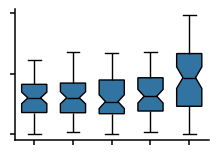

In [17]:
my_order = df.groupby(by=["method"])["abs_mean_deg"].mean().sort_values().index
print(my_order)
plt.figure(figsize=(2.5, 1.7))
sns.boxplot(data=df, x="method", y="abs_mean_deg", notch=True, width=0.65, showfliers=True, whis=1.5, order=my_order, **BXPLT_PROPS)
ax = plt.gca()
ax.set_yticks([0, 90, 180])
ax.set_yticklabels(["", "", ""])
ax.set_ylabel("")
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(["", "", "", "", ""])
ax.set_xlabel("")
ax.spines[['top', 'right']].set_visible(False)

In [18]:
# Friedman's test
df = df.query("bee_id != 'n47'")
m1 = df[df["method"] == "midpoint"]["abs_mean_deg"]
m2 = df[df["method"] == "right_only"]["abs_mean_deg"]
m3 = df[df["method"] == "left_only"]["abs_mean_deg"]
m4 = df[df["method"] == "single_antennae"]["abs_mean_deg"]
m5 = df[df["method"] == "no_antennae"]["abs_mean_deg"]

res = scipy.stats.friedmanchisquare(m1, m2, m3, m4, m5)
print(res)

# Posthocs
res = scikit_posthocs.posthoc_wilcoxon(df, val_col="abs_mean_deg", group_col="method", p_adjust="bonferroni")
print(res)

FriedmanchisquareResult(statistic=32.67586206896544, pvalue=1.3916306237689858e-06)
                 left_only  right_only  midpoint  no_antennae  single_antennae
left_only         1.000000    1.000000  1.000000     0.002116         1.000000
right_only        1.000000    1.000000  0.335637     0.002779         0.249995
midpoint          1.000000    0.335637  1.000000     0.000011         1.000000
no_antennae       0.002116    0.002779  0.000011     1.000000         0.000011
single_antennae   1.000000    0.249995  1.000000     0.000011         1.000000


### Ribbon plot: error versus angle to dancer (4B)

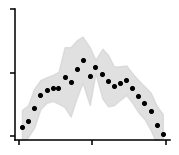

In [19]:
method = "midpoint"
tmp_bin_size = 24
binned_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}*{method}*{max_antenna_angle}MaxAntennaPos*-{tmp_bin_size}bins-binned_errors.csv"))[0])

plt.figure(figsize=(2, 1.7))
ribbon_low = np.abs(binned_df["mean_rad"]) - binned_df["std_rad"]
ribbon_high = np.abs(binned_df["mean_rad"]) + binned_df["std_rad"]
plt.fill_between(binned_df["angle_to_dancer_rad"], ribbon_low, ribbon_high, color="lightgray", alpha=0.7) 
plt.scatter(binned_df["angle_to_dancer_rad"], np.abs(binned_df["mean_rad"]), s=7, c="black")
ax = plt.gca()
ax.set_yticks([0, np.pi/2, np.pi])
ax.set_yticklabels(["", "", ""])
ax.set_ylabel("")
ax.set_ylim(np.radians(-6))
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels(["", "", ""])
ax.set_xlabel("")
ax.spines[['top', 'right']].set_visible(False)

### Boxplot: error versus angle to dancer by stability of nestmate (4C)

category
Changing    37
Stable      22
Name: count, dtype: int64


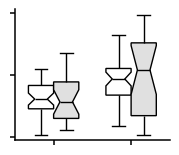

In [20]:
straightness_df = pd.read_csv(data_root / "orientation_straightness.csv")
straightness_df["category"] = straightness_df.apply(lambda bee: "Changing" if bee["straightness"] < 0.5 else "Stable", axis=1)
print(straightness_df["category"].value_counts())

method = "midpoint"
reduced_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}*{method}*-{nbins}bins-reduced_errors.csv"))[0])
reduced_df = pd.merge(left=reduced_df, right=straightness_df, on="bee_id", how="inner")
reduced_df["method"] = method

method = "no_antennae"
control_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}*{method}*-{nbins}bins-reduced_errors.csv"))[0])
control_df = pd.merge(left=control_df, right=straightness_df, on="bee_id", how="inner")
control_df["method"] = method

stability_df = pd.concat((reduced_df, control_df), axis=0)
stability_df["abs_mean_deg"] = np.degrees(np.abs(stability_df["mean_rad"]))
stability_df["group_col"] = stability_df.apply(lambda row: f"{row['method']}_{row['category']}", axis=1)

plt.figure(figsize=(2, 1.7))
sns.boxplot(data=stability_df, x="method", y="abs_mean_deg", hue="category", notch=True, width=0.65, showfliers=False, whis=1.5, palette=["white", "#E0E0E0"], **BXPLT_PROPS)
ax = plt.gca()
plt.ylim(-5)
ax.set_yticks([0, 90, 180])
ax.set_yticklabels(["", "", ""])
ax.set_ylabel("")
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("")
ax.set_xticks([0,1])
ax.set_xticklabels(["", ""])
plt.legend([],[], frameon=False)
plt.show()

In [21]:
# Comparing the same bees
# Comparison 1: changing when comparing midpt vs control
df_1a = stability_df[stability_df["group_col"] == "midpoint_Changing"]["abs_mean_deg"].values
df_1b = stability_df[stability_df["group_col"] == "no_antennae_Changing"]["abs_mean_deg"].values
res = scipy.stats.wilcoxon(df_1a, df_1b)
print(res, "\n")

# Comparison 2: stable when comparing midpt vs control
df_1a = stability_df[stability_df["group_col"] == "midpoint_Stable"]["abs_mean_deg"].values
df_1b = stability_df[stability_df["group_col"] == "no_antennae_Stable"]["abs_mean_deg"].values
res = scipy.stats.wilcoxon(df_1a, df_1b)
print(res)

WilcoxonResult(statistic=66.0, pvalue=2.736429451033473e-06) 

WilcoxonResult(statistic=45.0, pvalue=0.006649494171142578)


In [22]:
compare_df = stability_df[stability_df["group_col"].isin(["midpoint_Changing", "midpoint_Stable"])]
res = scipy.stats.kruskal(*compare_df.groupby("group_col")["abs_mean_deg"].apply(list).values)
print(res)
res = scikit_posthocs.posthoc_dunn(compare_df, val_col="abs_mean_deg", group_col="group_col")
print("Dunn's test post hoc:\n", res, "\n")

compare_df = stability_df[stability_df["group_col"].isin(["no_antennae_Changing", "no_antennae_Stable"])]
res = scipy.stats.kruskal(*compare_df.groupby("group_col")["abs_mean_deg"].apply(list).values)
print(res)
res = scikit_posthocs.posthoc_dunn(compare_df, val_col="abs_mean_deg", group_col="group_col")
print("Dunn's test post hoc:\n", res, "\n")

compare_df = stability_df[stability_df["group_col"].isin(["midpoint_Changing", "no_antennae_Stable"])]
res = scipy.stats.kruskal(*compare_df.groupby("group_col")["abs_mean_deg"].apply(list).values)
print(res)
res = scikit_posthocs.posthoc_dunn(compare_df, val_col="abs_mean_deg", group_col="group_col")
print("Dunn's test post hoc:\n", res, "\n")

compare_df = stability_df[stability_df["group_col"].isin(["midpoint_Stable", "no_antennae_Changing"])]
res = scipy.stats.kruskal(*compare_df.groupby("group_col")["abs_mean_deg"].apply(list).values)
print(res)
res = scikit_posthocs.posthoc_dunn(compare_df, val_col="abs_mean_deg", group_col="group_col")
print("Dunn's test post hoc:\n", res, "\n")

KruskalResult(statistic=0.019901719901724846, pvalue=0.8878119131967689)
Dunn's test post hoc:
                    midpoint_Changing  midpoint_Stable
midpoint_Changing           1.000000         0.887812
midpoint_Stable             0.887812         1.000000 

KruskalResult(statistic=0.49754299754300746, pvalue=0.4805817017029522)
Dunn's test post hoc:
                       no_antennae_Changing  no_antennae_Stable
no_antennae_Changing              1.000000            0.480582
no_antennae_Stable                0.480582            1.000000 

KruskalResult(statistic=3.4793611793611774, pvalue=0.06213872342827779)
Dunn's test post hoc:
                     midpoint_Changing  no_antennae_Stable
midpoint_Changing            1.000000            0.062139
no_antennae_Stable           0.062139            1.000000 

KruskalResult(statistic=5.602211302211288, pvalue=0.017937822911527675)
Dunn's test post hoc:
                       midpoint_Stable  no_antennae_Changing
midpoint_Stable             

### Polarplot: error over time (4D, S4D)

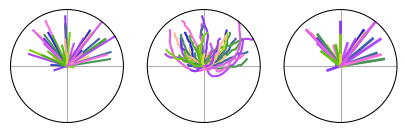

In [23]:
method = "midpoint"
method_csv = list((data_root).glob(f"{experiment_run_date}*{method}*{max_antenna_angle}MaxAntennaPos*-{nbins}bins-errors.csv"))[0]
df90 = pd.read_csv(method_csv)

fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection="polar"), dpi=100, figsize=(5, 3))
ax = ax.reshape(-1)
max_frame = 0
for bee_id in df90["bee_id"].unique():
    bee_midpt = df90[df90["bee_id"] == bee_id].sort_values("frame")
    max_frame = max(max_frame, bee_midpt["frame"].max())
    final_error = bee_midpt["vector_error_rad"].iloc[-1]
    final_frame = bee_midpt["frame"].iloc[-1]
    color = cmap(np.random.uniform(0, 1))
    ax[0].plot([0.0, final_error], [0, final_frame], color=color, linewidth=1.5)  # Error of final vector
    ax[1].plot(bee_midpt["vector_error_rad"], bee_midpt["frame"], color=color, linewidth=1.5)  # Error on each step
    min_error_idx = (np.abs(bee_midpt["vector_error_deg"] - 0.0)).argmin()
    min_error = bee_midpt["vector_error_rad"].iloc[min_error_idx]
    ax[2].plot([0.0, min_error], [0.0, min_error_idx+1], linewidth=2.0, color=color)  # Error of best vector

max_frame = 400  # 2 s
ax[0].set_ylim(0, max_frame)
ax[0].set_yticklabels("")
ax[0].set_yticks([])
ax[0].set_yticklabels([])
lw = 0.7
circle = plt.Circle((0.0, 0.0), max_frame, transform=ax[0].transData._b, fill=False, linewidth=1.5, zorder=2)
ax[0].add_artist(circle)
ax[0].axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[0].axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[0].axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[0].axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[0].set_theta_zero_location("N")
ax[0].set_thetamin(-180)
ax[0].set_thetamax(180)
ax[0].set_thetagrids([0, 90, 180, -90], fontsize=11)
ax[0].set_xticklabels(["", "", "", ""])
ax[0].spines['polar'].set_visible(False)

ax[1].set_ylim(0, max_frame)
ax[1].set_yticklabels("")
ax[1].set_yticks([])
ax[1].set_yticklabels([])
circle = plt.Circle((0.0, 0.0), max_frame, transform=ax[1].transData._b, fill=False, linewidth=1.5, zorder=2)
ax[1].add_artist(circle)
ax[1].axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[1].axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[1].axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[1].axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[1].set_theta_zero_location("N")
ax[1].set_thetamin(-180)
ax[1].set_thetamax(180)
ax[1].set_thetagrids([0, 90, 180, -90], fontsize=11)
ax[1].set_xticklabels(["", "", "", ""])
ax[1].spines['polar'].set_visible(False)

ax[2].set_ylim(0, max_frame)
ax[2].set_yticklabels("")
ax[2].set_yticks([])
ax[2].set_yticklabels([])
circle = plt.Circle((0.0, 0.0), max_frame, transform=ax[2].transData._b, fill=False, linewidth=1.5, zorder=2)
ax[2].add_artist(circle)
ax[2].axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[2].axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[2].axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[2].axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax[2].set_theta_zero_location("N")
ax[2].set_thetamin(-180)
ax[2].set_thetamax(180)
ax[2].set_thetagrids([0, 90, 180, -90], fontsize=11)
ax[2].set_xticklabels(["", "", "", ""])
ax[2].spines['polar'].set_visible(False)

### Ribbon plot: error versus nestmate's gravity angle (S4A)

In [24]:
method = "midpoint"
tmp_bin_size = 4
features_df = pd.read_csv(data_root / f"{experiment_run_date}-features.csv")
features_df = features_df[["bee_id", "frame", "recruit_angle_to_gravity_rad"]]
errors_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}*{method}*{max_antenna_angle}MaxAntennaPos*-{tmp_bin_size}bins-errors.csv"))[0])
errors_df = errors_df[["bee_id", "frame", "angle_to_dancer_deg", "vector_error_deg"]]

bee_to_gravity_angle = {}
for bee_id, bee_df in errors_df.groupby("bee_id"):
    bee_features = features_df[features_df["bee_id"] == bee_id]
    mean_angle_to_gravity = scipy.stats.circmean(bee_features["recruit_angle_to_gravity_rad"], low=-np.pi, high=np.pi)
    bee_to_gravity_angle[bee_id] = mean_angle_to_gravity
bee_to_gravity_angle = pd.Series(bee_to_gravity_angle, name="recruit_angle_to_gravity_rad").reset_index().rename(columns={"index": "bee_id"})
errors_gravity_df = pd.merge(left=errors_df, right=bee_to_gravity_angle, on=["bee_id"], how="inner")

def reduce(bee_df: pd.DataFrame):
    """Reduce data: mean and std of vector error, mean angle to dancer."""
    vector_error_rad = np.abs(np.radians(bee_df["vector_error_deg"]))
    mean_vector_error_rad = scipy.stats.circmean(
        vector_error_rad, high=np.pi, low=0
    )
    mean_vector_error_std = scipy.stats.circstd(
        vector_error_rad, high=np.pi, low=0
    ) 
    mean_angle_to_gravity = scipy.stats.circmean(
        bee_df["recruit_angle_to_gravity_rad"], high=np.pi, low=-np.pi
    ) 
    return mean_vector_error_rad, mean_vector_error_std, mean_angle_to_gravity

bins = np.array([0, np.radians(45), np.radians(135), np.radians(225), np.radians(315), np.radians(360)])
def circular_bin(x):
    """Bin angles into circular bins."""
    assigned_bins = np.digitize(x, bins) - 1
    assigned_bins[assigned_bins == 4] = 0  # Merge first and last bin
    return assigned_bins

errors_gravity_df["remapped_gravity_rad"] = errors_gravity_df["recruit_angle_to_gravity_rad"].apply(lambda x: (x + 2*np.pi) %  2*np.pi)
errors_gravity_df["bin_idx_of_angle_to_gravity_rad"] = circular_bin(errors_gravity_df["remapped_gravity_rad"])
errors_gravity_df["abs_vector_error_deg"] = np.abs(errors_gravity_df["vector_error_deg"])
bee_errors = (
    errors_gravity_df.groupby("bee_id")
    .apply(lambda group: reduce(group))
    .reset_index()
)
bee_errors = pd.concat([bee_errors.drop([0], axis=1), bee_errors[0].apply(pd.Series)], axis=1)
bee_errors = bee_errors.rename(columns={0: "vector_error_deg", 1: "std_rad", 2: "recruit_angle_to_gravity_rad"})
errors_gravity_df = errors_gravity_df[["bee_id", "bin_idx_of_angle_to_gravity_rad"]].drop_duplicates()
bee_errors = pd.merge(left=bee_errors, right=errors_gravity_df, on=["bee_id"], how="inner")
mean = np.degrees(bee_errors.groupby("bin_idx_of_angle_to_gravity_rad").apply(lambda group: reduce(group)[0]))
std = np.degrees(bee_errors.groupby("bin_idx_of_angle_to_gravity_rad").apply(lambda group: reduce(group)[1]))
print(bee_errors.groupby("bin_idx_of_angle_to_gravity_rad").size())

bin_idx_of_angle_to_gravity_rad
0    16
1    12
2    15
3    16
dtype: int64


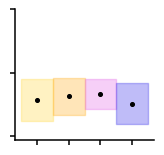

In [25]:
plt.figure(figsize=(1.8, 1.7))
ribbon_low = np.abs(mean) - std
ribbon_high = np.abs(mean) + std
bins_adj = np.array([0.0, np.radians(90), np.radians(180), np.radians(270)])

offset = np.radians(45)
colours = ["#FFD737", "#FFAA14", "#E260E7", "#2C24E9"]
for i, bin_pos in enumerate(bins_adj):
    plt.fill_between(x=[bin_pos-offset,bin_pos+offset], y1=ribbon_low[i], y2=ribbon_high[i], color=colours[i], alpha=0.3)

plt.scatter(bins_adj, np.abs(mean), s=7, c="black")
ax = plt.gca()
ax.set_yticks([0, np.pi/2, np.pi])
ax.set_yticklabels(["", "", ""])
ax.set_ylabel("")
ax.set_ylim(np.radians(-6))
ax.set_xticks(bins_adj)
ax.set_xticklabels(["", "", "", ""])
ax.set_xlabel("")
ax.spines[['top', 'right']].set_visible(False)

### Scatterplot: error versus time spent following nestmate (S4B)

59 phases
Pearson's: 0.032561065675311286 p-value: 0.8065959056246168


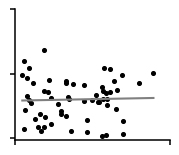

In [26]:
method = "midpoint"
reduced_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}*{method}*-{nbins}bins-reduced_errors.csv"))[0])
print(reduced_df["bee_id"].unique().shape[0], "phases")

y = np.degrees(np.abs(reduced_df["mean_rad"]))
x = reduced_df["num_frames_following"]
r, p = scipy.stats.pearsonr(x, y)
print("Pearson's:", r, "p-value:", p)

plt.figure(figsize=(2, 1.7))
plt.scatter(x, y, s=7, color="black")

fit_params = np.polyfit(x, y, 1)
x = np.unique(x)
y_fit = np.poly1d(fit_params)(x)
plt.plot(x, y_fit, color="gray")

ax = plt.gca()
ax.set_yticks([0, 90, 180])
ax.set_yticklabels(["", "", ""])
ax.set_ylabel("")
ax.set_xticks([0, 500])
ax.set_xticklabels(["", ""])
ax.set_xlabel("")
ax.spines[['top', 'right']].set_visible(False)

### Histogram: angular error vs max antenna positions (S4C right)

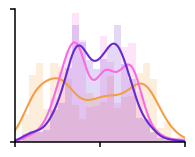

In [27]:
methods = [
   "midpoint",
   "no_antennae",
]
dfs = {}
for method in methods:
    method_csv = list((data_root).glob(f"{experiment_run_date}*{method}*{max_antenna_angle}MaxAntennaPos*-{nbins}bins-errors.csv"))[0]
    dfs[method] = pd.read_csv(method_csv)
df = pd.concat((dfs), axis=0).reset_index().drop(columns=["level_1"]).rename(columns={"level_0": "method"})
df["max_antenna_pos"]  = max_antenna_angle

dfs = {}
tmp_max_antenna_pos = 60
for method in methods:
    method_csv = list((data_root).glob(f"{experiment_run_date}*{method}*{tmp_max_antenna_pos}MaxAntennaPos*-{nbins}bins-errors.csv"))[0]
    dfs[method] = pd.read_csv(method_csv)
df1 = pd.concat((dfs), axis=0).reset_index().drop(columns=["level_1"]).rename(columns={"level_0": "method"})
df1["max_antenna_pos"]  = tmp_max_antenna_pos
df1 = df1[df1["method"] != "no_antennae"]

df = pd.concat((df, df1), axis=0)
df["category"] = df["method"] + "_" + df["max_antenna_pos"].astype(str)

subdf = df[df["category"].isin(["midpoint_90", "midpoint_60", "no_antennae_90"])]
pallette = {"midpoint_90": "#F86BE2", "midpoint_60": "#672ad1","no_antennae_90": "#F29F46"}
sns.displot(subdf, x="vector_error_deg", hue="category", kde=True, alpha=0.18, bins=24, ec="none", height=2.65, aspect=1.3,kde_kws={"bw_adjust":1.8}, legend=False, palette=pallette, hue_order=["midpoint_60", "midpoint_90","no_antennae_90"])
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
plt.xlim(-180, 180)
ax.set_xticks([-180, 0, 180])
ax.set_xticklabels(["", "", ""])
plt.xlabel("")
plt.ylabel("")
plt.yticks([0, 1400])
ax.set_yticklabels(["",""])
plt.ylim(0, 1400)
plt.show()

### Boxplots: angular error vs max antenna positions (S4C left)

In [28]:
methods = [
   "midpoint",
   "left_only",
   "right_only",
   "single_antennae",
]
dfs = {}
for method in methods:
    method_csv = list((data_root).glob(f"{experiment_run_date}*{method}*{max_antenna_angle}MaxAntennaPos*-{nbins}bins-reduced_errors.csv"))[0]
    dfs[method] = pd.read_csv(method_csv)
df = pd.concat((dfs), axis=0).reset_index().drop(columns=["level_1"]).rename(columns={"level_0": "method"})
df["max_antenna_pos"]  = max_antenna_angle

dfs = {}
tmp_max_antenna_pos = 60
for method in methods:
    method_csv = list((data_root).glob(f"{experiment_run_date}*{method}*{tmp_max_antenna_pos}MaxAntennaPos*-{nbins}bins-reduced_errors.csv"))[0]
    dfs[method] = pd.read_csv(method_csv)
df1 = pd.concat((dfs), axis=0).reset_index().drop(columns=["level_1"]).rename(columns={"level_0": "method"})
df1["max_antenna_pos"]  = tmp_max_antenna_pos
df = pd.concat((df1, df), axis=0)

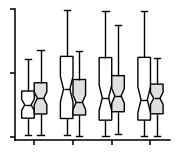

In [29]:
plt.figure(figsize=(2, 1.7))
df["abs_mean_deg"] = np.abs(np.degrees(df["mean_rad"]))
df["abs_final_error_deg"] = np.abs(np.degrees(df["final_vector_rad"]))
sns.boxplot(df, y="abs_mean_deg", x="method", hue="max_antenna_pos", notch=True, width=0.65, showfliers=False, whis=1.5, palette=["white", "#E0E0E0"], **BXPLT_PROPS)
plt.legend([],[], frameon=False)
ax = plt.gca()
ax.set_yticks([0, 90, 180])
ax.set_ylim([-5,180])
ax.set_yticklabels(["", "", ""])
ax.set_ylabel("")
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["", "", "", ""])
ax.set_xlabel("")
ax.spines[['top', 'right']].set_visible(False)

# Vector assimilation: vector averaging (Figs 4, S4)

### Boxplot: error when averaging consecutive phases (4E)

In [30]:
method = "midpoint"
errors_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}*{method}*{max_antenna_angle}Max*-errors.csv"))[0])
method = "no_antennae"
control_errors_df = pd.read_csv(list((data_root).glob(f"{experiment_run_date}*{method}*{max_antenna_angle}Max*-errors.csv"))[0])

def get_bee_id_parent(bee_id):  # Create waggle run index column for each bee
    name_components = bee_id.split("_")  # i.e. "n9", "n9_1"
    parent_name = name_components[0]
    if len(name_components) == 1:
        return parent_name, 0
    return parent_name, int(name_components[1])

def return_consec_waggles_df(errors_df):
    parent_to_consensus_angles = {}
    for name, group in errors_df.groupby("bee_id_parent"):
        combinations = group["waggle_run_idx"].unique()
        combinations = [combinations[: i + 1] for i in range(len(combinations))]
        parent_to_consensus_angles[name] = {}
        for comb in combinations:
            angles_so_far = group[group["waggle_run_idx"].isin(comb)][
                "vector_error_rad"
            ].values
            mean_angle = scipy.stats.circmean(angles_so_far, high=np.pi, low=-np.pi)
            parent_to_consensus_angles[name][f"over_time_{comb.max()}"] = mean_angle
            parent_to_consensus_angles[name][f"final_vec_{comb.max()}"] = angles_so_far[-1]
    consec_waggle_runs_df = (
        pd.DataFrame(parent_to_consensus_angles)
        .T.reset_index()
        .rename(columns={"index": "bee_id"})
    )
    return consec_waggle_runs_df

errors_df["bee_id_parent"], errors_df["waggle_run_idx"] = zip(
    *errors_df["bee_id"].apply(get_bee_id_parent)
)
errors_df = errors_df.sort_values(by=["bee_id_parent", "waggle_run_idx"])
consec_waggle_runs_df = return_consec_waggles_df(errors_df)
consec_waggle_runs_df["method"] = "midpoint"

control_errors_df["bee_id_parent"], control_errors_df["waggle_run_idx"] = zip(
    *control_errors_df["bee_id"].apply(get_bee_id_parent)
)
control_errors_df = control_errors_df.sort_values(by=["bee_id_parent", "waggle_run_idx"])
control_consec_waggle_runs_df = return_consec_waggles_df(control_errors_df)
control_consec_waggle_runs_df["method"] = "no_antennae"

consec_waggle_runs_df = pd.concat((consec_waggle_runs_df, control_consec_waggle_runs_df), axis=0)
followed_multiple = consec_waggle_runs_df.dropna(subset=["over_time_1"], axis=0)  # Bees that followed multiple phases
followed_multiple = followed_multiple.melt(id_vars=["bee_id", "method"])
followed_multiple["condition"] = followed_multiple["variable"].apply(
    lambda x: x.split("_")[0]
)
followed_multiple["run_number"] = followed_multiple["variable"].apply(
    lambda x: x.split("_")[2]
)
averaged_over_all_runs = followed_multiple.groupby(["method", "condition", "bee_id"]).apply(lambda x: scipy.stats.circmean(x["value"].dropna(), high=np.pi, low=-np.pi))
averaged_over_all_runs = averaged_over_all_runs.reset_index().rename(columns={0: "value"})
averaged_over_all_runs["vector_averaging"] = "True"
averaged_over_all_runs = averaged_over_all_runs.reindex(sorted(averaged_over_all_runs.columns), axis=1)

# To separate out those that only followed one phase from those that followed multiple
first_run_only = consec_waggle_runs_df[~consec_waggle_runs_df["bee_id"].isin(followed_multiple["bee_id"].unique())]
first_run_only = first_run_only.melt(id_vars=["bee_id", "method"]).dropna()
first_run_only["condition"] = first_run_only["variable"].apply(
    lambda x: x.split("_")[0]
)
first_run_only = first_run_only.drop(columns=["variable"])
first_run_only["vector_averaging"] = "False"
first_run_only = first_run_only.reindex(sorted(first_run_only.columns), axis=1)
# To add the first phase of those that followed multiple phases 
# first_run_only = consec_waggle_runs_df.dropna(axis=1).melt(id_vars=["bee_id", "method"]).dropna()
# first_run_only["condition"] = first_run_only["variable"].apply(
#     lambda x: x.split("_")[0]
# )
# first_run_only["vector_averaging"] = "False"
# first_run_only = first_run_only.drop(columns=["variable"])
# first_run_only = first_run_only.reindex(sorted(first_run_only.columns), axis=1)

df = pd.concat((first_run_only, averaged_over_all_runs), axis=0)
df = df[(df["condition"] != "over")]
df["abs_deg"] = np.abs(np.degrees(df["value"]))

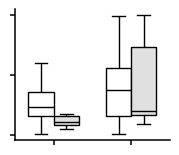

In [31]:
plt.figure(figsize=(2, 1.7))
ax = sns.boxplot(df, x="method", y="abs_deg", hue="vector_averaging", width=0.65, showfliers=False, whis=1.5, palette=["white", "#E0E0E0"], **BXPLT_PROPS)
ax.set_yticks([0, 90, 180])
ax.set_yticklabels(["", "", ""])
ax.set_ylabel("")
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("")
ax.set_xticks([0, 1])
ax.set_xticklabels(["", ""])
plt.legend([],[], frameon=False)
plt.show()

In [32]:
df["method_condition"] = df["method"] + "_" + df["vector_averaging"]

# Comparing the same bees
# Comparison 1: vec averaging when comparing midpt vs control
df_1a = df[df["method_condition"] == "midpoint_True"]["abs_deg"].values
df_1b = df[df["method_condition"] == "no_antennae_True"]["abs_deg"].values
res = scipy.stats.wilcoxon(df_1a, df_1b)
print(res)

# Comparison 2: first phase when comparing midpt vs control
df_1a = df[df["method_condition"] == "midpoint_False"]["abs_deg"].values
df_1b = df[df["method_condition"] == "no_antennae_False"]["abs_deg"].values
res = scipy.stats.wilcoxon(df_1a, df_1b)
print("\n", res)

WilcoxonResult(statistic=2.0, pvalue=0.01171875)

 WilcoxonResult(statistic=88.0, pvalue=1.1313175491522998e-05)


In [33]:
compare_df = df[df["method_condition"].isin(["midpoint_True", "midpoint_False"])]
res = scipy.stats.kruskal(*compare_df.groupby("method_condition")["abs_deg"].apply(list).values)
print(res)
# Dunn's test Post hoc pairwise test for multiple comparisons of mean rank sums, following Kruskal Wallis test
res = scikit_posthocs.posthoc_dunn(compare_df, val_col="abs_deg", group_col="method_condition")
print("Dunn's test post hoc:\n", res)

compare_df = df[df["method_condition"].isin(["no_antennae_True", "no_antennae_False"])]
res = scipy.stats.kruskal(*compare_df.groupby("method_condition")["abs_deg"].apply(list).values)
print(res)
# Dunn's test Post hoc pairwise test for multiple comparisons of mean rank sums, following Kruskal Wallis test
res = scikit_posthocs.posthoc_dunn(compare_df, val_col="abs_deg", group_col="method_condition")
print("Dunn's test post hoc:\n", res)

compare_df = df[df["method_condition"].isin(["no_antennae_True", "midpoint_False"])]
res = scipy.stats.kruskal(*compare_df.groupby("method_condition")["abs_deg"].apply(list).values)
print(res)
# Dunn's test Post hoc pairwise test for multiple comparisons of mean rank sums, following Kruskal Wallis test
res = scikit_posthocs.posthoc_dunn(compare_df, val_col="abs_deg", group_col="method_condition")
print("Dunn's test post hoc:\n", res)

compare_df = df[df["method_condition"].isin(["no_antennae_False", "midpoint_True"])]
res = scipy.stats.kruskal(*compare_df.groupby("method_condition")["abs_deg"].apply(list).values)
print(res)
# Dunn's test Post hoc pairwise test for multiple comparisons of mean rank sums, following Kruskal Wallis test
res = scikit_posthocs.posthoc_dunn(compare_df, val_col="abs_deg", group_col="method_condition")
print("Dunn's test post hoc:\n", res)

KruskalResult(statistic=5.281432748538009, pvalue=0.02155400439253743)
Dunn's test post hoc:
                 midpoint_False  midpoint_True
midpoint_False        1.000000       0.021554
midpoint_True         0.021554       1.000000
KruskalResult(statistic=0.04678362573099548, pvalue=0.8287576284011177)
Dunn's test post hoc:
                    no_antennae_False  no_antennae_True
no_antennae_False           1.000000          0.828758
no_antennae_True            0.828758          1.000000
KruskalResult(statistic=0.7960526315789593, pvalue=0.3722761945041738)
Dunn's test post hoc:
                   midpoint_False  no_antennae_True
midpoint_False          1.000000          0.372276
no_antennae_True        0.372276          1.000000
KruskalResult(statistic=7.60526315789474, pvalue=0.005819816954009846)
Dunn's test post hoc:
                    midpoint_True  no_antennae_False
midpoint_True            1.00000            0.00582
no_antennae_False        0.00582            1.00000


### Heatmap: transition probabilities (4F)

{'tp_rr': 0.25925925925925924, 'tp_rl': 0.7407407407407407, 'tp_ll': 0.25, 'tp_lr': 0.75, 'index': 0.6204561042524006}


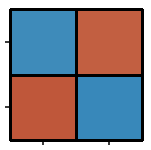

In [34]:
def compute_predictability(LL, RR, RL, LR) -> dict:
    """Compute the predictability index for all entries in given dict."""
    if (
        RR + RL == 0
        or LL + LR == 0
    ):
        return -1
    res = {}
    tp_rr = RR / (RR + RL)
    tp_rl = RL / (RR + RL)
    tp_ll = LL / (LL + LR)
    tp_lr = LR / (LL + LR)
    res["tp_rr"] = tp_rr
    res["tp_rl"] = tp_rl
    res["tp_ll"] = tp_ll
    res["tp_lr"] = tp_lr
    res["index"] = 1 - (tp_rr * tp_rl + tp_ll * tp_lr)
    return res

LL = 6
RR = 7 
RL = 20
LR = 18
pred = compute_predictability(LL, RR, RL, LR)
print(pred)
data = np.array([[pred["tp_rr"], pred["tp_rl"]], [pred["tp_lr"], pred["tp_ll"]]])
plt.figure(figsize=(1.7,1.7))
ax = sns.heatmap(data, vmin=0, vmax=1, cmap=cmocean.cm.balance, linewidths=1, linecolor='black',clip_on=False, cbar=False)
ax.set_xticklabels("")
ax.set_yticklabels("")
plt.show()

In [35]:
# Chi square test of independence: transition probabilities
obs = np.array([[LL, LR], [RL, RR]])
chi2, p, dof, ex = scipy.stats.chi2_contingency(obs)
print("Chi2:", chi2, ", p:", p, ", dof:", dof)
print("expected counts:\n", ex)

Chi2: 10.359374999999996 , p: 0.0012881880956681674 , dof: 1
expected counts:
 [[12.23529412 11.76470588]
 [13.76470588 13.23529412]]


### Polarplot: phase averaging example (4G)

In [36]:
method = "midpoint"
method_csv = list((data_root).glob(f"{experiment_run_date}*{method}*{max_antenna_angle}MaxAntennaPos*-{nbins}bins-errors.csv"))[0]
df = pd.read_csv(method_csv)
bee = "RF5"
phase1_df = df[df["bee_id"] == f"{bee}"]
phase2_df = df[df["bee_id"] == f"{bee}_1"]
phase3_df = df[df["bee_id"] == f"{bee}_2"]

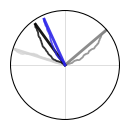

In [37]:
plt.figure(figsize=(2, 1.7))
ax = plt.subplot(projection='polar')
colours = {0: "lightgray", 1:"gray", 2:"black"}
vectors = []
for i, phase_df in enumerate([phase1_df, phase2_df, phase3_df]):
    vectors.append(phase_df["vector_error_rad"].values[:270])
    final_error = phase_df["vector_error_rad"].iloc[-1]
    ax.plot([0.0, final_error], [0, phase_df["frame"].iloc[-1]], color=colours[i], linewidth=2.0, alpha=0.9)
    ax.plot(phase_df["vector_error_rad"], phase_df["frame"], color=colours[i], linewidth=1.3, alpha=0.8)

final_frame = 270
my_colors = ["#2E22EA","#9E3DFB","#F86BE2","#FCCE7B","#C4E416","#4BBA0F","#447D87","#2C24E9"]
mean_dir = scipy.stats.circmean(vectors, axis=0, high=np.pi, low=-np.pi)
ax.plot(mean_dir, range(mean_dir.shape[0]), color=my_colors[7], linewidth=1.3, alpha=0.8)
ax.plot([0, mean_dir[-1]], [0, final_frame], color=my_colors[7], alpha=0.9, linewidth=2.0)

ylim = 295
lw = 0.7
ax.set_yticklabels("")
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(180)
ax.set_thetagrids([0, 90, 180, -90], fontsize=11)
ax.spines['polar'].set_visible(False)
ax.set_xticklabels(["", "", "", ""])
ax.grid(False)
ax.set_ylim(0, ylim)
circle = plt.Circle((0.0, 0.0), ylim, transform=ax.transData._b, fill=False, linewidth=1.5, zorder=2)
ax.add_artist(circle)
ax.axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
plt.tight_layout()

In [38]:
df = pd.read_csv(f"{data_root / experiment_run_date}-features.csv")
rf5_df = df[df["bee_id"].isin(["RF5", "RF5_1", "RF5_2"])]
mean_waggle_dirs = rf5_df.groupby("bee_id").apply(lambda row: scipy.stats.circmean(row["dancers_angle_to_gravity_rad"], high=np.pi, low=-np.pi))
print("Mean waggle dir", np.degrees(scipy.stats.circmean(mean_waggle_dirs, high=np.pi, low=-np.pi)), "deg")
print(np.degrees(mean_waggle_dirs))

Mean waggle dir -59.44979672335144 deg
bee_id
RF5     -59.791025
RF5_1   -65.711306
RF5_2   -52.844898
dtype: float64


# Misc

### Simplified modelled antennal relationship (Fig. 3A)

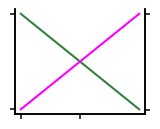

In [39]:
# Target angles relative to dancer
stepsize = np.radians(1)
pos_half = np.arange(0.0, np.pi + stepsize, stepsize)
neg_half = np.arange(-np.pi, 0.0, stepsize)
VALID_ANGLES_TO_DANCER = np.concatenate((pos_half, neg_half))

# Vaild antennae positions
max_antenna_pos = np.pi / 2
step = max_antenna_pos / VALID_ANGLES_TO_DANCER.shape[0]
right_antennae = np.flip(np.arange(-max_antenna_pos, 0, step))
left_antennae = np.flip(np.arange(0, max_antenna_pos, step))

fig, ax1 = plt.subplots(figsize=(2, 1.7))
plt.xticks([0, 180])
ax1.set_xticklabels(["", ""])
ax1.set_yticks([0, 90])
ax1.set_yticklabels(["", ""])
ax1.plot(np.degrees(left_antennae), color="#33813E")  # Angle to dancer (x) vs. left antenna (y)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.plot(np.degrees(right_antennae), color="#FB00FF") # Angle to dancer (x) vs. right antenna (y)
ax2.tick_params(axis='y')
ax2.invert_yaxis()
ax2.set_yticks([0, -90])
ax2.set_yticklabels(["", ""])
fig.tight_layout()
ax2.spines[['top']].set_visible(False)
ax1.spines[['top']].set_visible(False)

### Scatterplot: model predictions (full length left and right antenna) (Fig. S2D top)

In [40]:
model_fit_df = pd.read_csv("datasets/full_antenna_length_fit_predictions.csv").drop(columns=["Unnamed: 0"])
model_fit_df["actual_deg"] = np.degrees(model_fit_df["actual"])
model_fit_df["angle_to_dancer_deg"] = np.degrees(model_fit_df["angle_to_dancer_rad"])

y = model_fit_df["angle_to_dancer_deg"]
x = model_fit_df["actual_deg"]
r, p = scipy.stats.pearsonr(x, y)
print("Pearson's:", r)

Pearson's: 0.6544236827380582


Pearson's: 0.6845340298553478


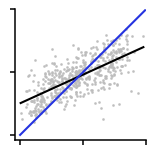

In [41]:
sample = model_fit_df.sample(500)
plt.figure(figsize=(1.8, 1.7))
plt.scatter(sample["actual_deg"], sample["angle_to_dancer_deg"], s=1, color="#BCBCBC", alpha=0.8)
plt.plot(np.unique(sample["actual_deg"]), np.poly1d(np.polyfit(sample["actual_deg"], sample["angle_to_dancer_deg"], 1))(np.unique(sample["actual_deg"])), color="black")
plt.plot([0, 358], [0, 357], color="#2533e0")
plt.ylim(-15, 360)
plt.xlim(-15, 360)
plt.xticks([0, 180, 360])
plt.yticks([0, 180, 360])
ax = plt.gca()
ax.set_aspect("equal")
ax.set_yticklabels(["", "", ""])
ax.set_xticklabels(["", "", ""])
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("")
plt.ylabel("")
y = sample["angle_to_dancer_deg"]
x = sample["actual_deg"]
r, p = scipy.stats.pearsonr(x, y)
print("Pearson's:", r)

### Scatterplot: model predictions (mid length left and right antenna) (Fig. S2D bottom)

In [42]:
model_fit_df = pd.read_csv("datasets/mid_antenna_length_fit_predictions.csv").drop(columns=["Unnamed: 0"])
model_fit_df["actual_deg"] = np.degrees(model_fit_df["actual"])
model_fit_df["angle_to_dancer_deg"] = np.degrees(model_fit_df["angle_to_dancer_rad"])
y = model_fit_df["angle_to_dancer_deg"]
x = model_fit_df["actual_deg"]
r, p = scipy.stats.pearsonr(x, y)
print("Pearson's:", r)

Pearson's: 0.5671429741237555


Pearson's: 0.5728807262138995


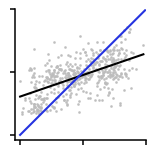

In [43]:
sample = model_fit_df.sample(500)
plt.figure(figsize=(1.8, 1.7))
plt.scatter(sample["actual_deg"], sample["angle_to_dancer_deg"], s=1, color="#BCBCBC", alpha=0.8)
plt.plot(np.unique(sample["actual_deg"]), np.poly1d(np.polyfit(sample["actual_deg"], sample["angle_to_dancer_deg"], 1))(np.unique(sample["actual_deg"])), color="black")
plt.plot([0, 358], [0, 357], color="#2533e0")
plt.ylim(-15, 360)
plt.xlim(-15, 360)
plt.xticks([0, 180, 360])
plt.yticks([0, 180, 360])
ax = plt.gca()
ax.set_aspect("equal")
ax.set_yticklabels(["", "", ""])
ax.set_xticklabels(["", "", ""])
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("")
plt.ylabel("")
y = sample["angle_to_dancer_deg"]
x = sample["actual_deg"]
r, p = scipy.stats.pearsonr(x, y)
print("Pearson's:", r)

### Activity plots: synthetic example (Fig. 3E)

In [ ]:
# Generate synthetic data to feed to assimilation circuit
# recruits_headings = np.concatenate(
#     (
#         (np.arange(np.radians(180), np.radians(0), np.radians(-1))),
#         -np.arange(np.radians(0), np.radians(180), np.radians(1)),
#     )
# )
# noise = np.random.default_rng().vonmises(0.0, 2.0, recruits_headings.shape[0])
# smoothed_noise = scipy.ndimage.gaussian_filter1d(noise, sigma=2)
# recruits_headings += smoothed_noise
# recruits_headings = scipy.ndimage.gaussian_filter1d(recruits_headings, sigma=3)
# dancers_headings = np.array([np.radians(-90.0)] * len(recruits_headings))
# noise = np.random.default_rng().vonmises(0.0, 10.0, dancers_headings.shape[0])
# smoothed_noise = scipy.ndimage.gaussian_filter1d(noise, sigma=8)
# dancers_headings += smoothed_noise
# np.savez(
#     "model_sim_data.npz",
#     dancers_headings=dancers_headings,
#     recruits_headings=recruits_headings,
# )

/var/folders/zk/_6v92pbn1jb2gnrh76qkpng1y98vd4/T/ipykernel_96160/4233445603.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "", "", ""])


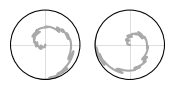

In [44]:
sim_data = np.load("datasets/model_sim_data_extra.npz")

plt.figure(figsize=(2, 1))
ax = plt.subplot(121, projection="polar")
ax2 = plt.subplot(122, projection='polar')

ax.plot(
    sim_data["recruits_headings"],
    range(sim_data["recruits_headings"].shape[0]),
    color="darkgray"
)
ax2.plot(
    sim_data["angles_to_dancer"],
    range(sim_data["angles_to_dancer"].shape[0]),
    color="darkgray"
)

ax.set_yticks([])
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(180)
plt.thetagrids([0, 90, 180, -90], fontsize=16)
ylim = sim_data["recruits_headings"].shape[0]
lw = 0.7
ax.spines['polar'].set_visible(False)
ax.set_xticklabels(["", "", "", ""])
ax.grid(False)
ax.set_ylim(0, ylim)
circle = plt.Circle((0.0, 0.0), ylim, transform=ax.transData._b, fill=False, linewidth=1.5, zorder=2)
ax.add_artist(circle)
ax.axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax.axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)

ax2.set_yticks([])
ax2.set_theta_zero_location("N")
ax2.set_thetamin(-180)
ax2.set_thetamax(180)
plt.thetagrids([0, 90, 180, -90], fontsize=16)
ylim = sim_data["recruits_headings"].shape[0]
lw = 0.7
ax2.spines['polar'].set_visible(False)
ax2.set_xticklabels(["", "", "", ""])
ax2.grid(False)
ax2.set_ylim(0, ylim)
circle = plt.Circle((0.0, 0.0), ylim, transform=ax2.transData._b, fill=False, linewidth=1.5, zorder=2)
ax2.add_artist(circle)
ax2.axvline(0, 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax2.axvline(np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax2.axvline(np.radians(90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
ax2.axvline(np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=0.5)
plt.show()

/var/folders/zk/_6v92pbn1jb2gnrh76qkpng1y98vd4/T/ipykernel_96160/3270901445.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


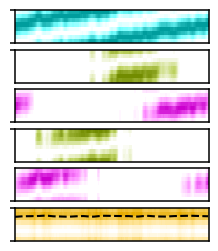

In [45]:
def remap_angles(angles):
    angles[angles < 0] += 360
    angles = angles / 45
    return angles

cx_events = np.load("datasets/20231115-2112/d307db75f52f568339e3a99ad9fba8a6/cx_events.npz")

f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, dpi=100)
f.set_size_inches(2.5, 3)

colors = ["white", "#75ffff", "#009d9d"]
cm = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", colors, N=30)
ax1.pcolormesh(cx_events["epg"].T, vmin=0, vmax=1, cmap=cm)

colors = ["white", "#bfd363ff", "#728c00ff"]
green_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", colors, N=30)
colors = ["white", "#fd8affff", "#cb00ceff"]
purple_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", colors, N=30)
ax2.pcolormesh(cx_events["pfnd"].T[:8,], vmin=0.0, vmax=1.0, cmap=green_cmap, linewidth=0, edgecolor="none")
ax3.pcolormesh(cx_events["pfnd"].T[8:,], vmin=0.0, vmax=1.0, cmap=purple_cmap, linewidth=0, edgecolor="none")
ax4.pcolormesh(cx_events["pfnv"].T[:8,], vmin=0.0, vmax=1.0, cmap=green_cmap, linewidth=0, edgecolor="none")
ax5.pcolormesh(cx_events["pfnv"].T[8:,], vmin=0.0, vmax=1.0, cmap=purple_cmap, linewidth=0, edgecolor="none")

colors = ["#e6ac01", "#ffe599ff", "white"]
cm1 = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", colors, N=30)
ax6.pcolormesh(cx_events["hdelta"].T, vmin=0.0, vmax=1.2, cmap=cm1)
angles = remap_angles(np.degrees(sim_data["dancers_headings"]))
ax6.plot(angles, "--", color="black")

ax1.set_yticks([0, 8])
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.set_xticks([])
ax2.set_yticks([8])
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([])
ax3.set_yticks([0])
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_xticks([])
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
ax4.set_xticks([])
ax4.set_yticks([8])
plt.setp(ax4.get_yticklabels(), visible=False)
ax5.set_xticks([])
ax5.set_yticks([0])
plt.setp(ax5.get_yticklabels(), visible=False)
ax6.set_xticks([])
ax6.set_yticks([0, 8])
plt.setp(ax6.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=0.2)

### Antennal noise (Fig. 3F)

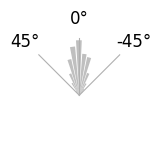

In [46]:
plt.figure(figsize=(1.5,1.5))
ax = plt.subplot(projection="polar")
samples_left = np.random.default_rng().vonmises(0, 10.0, 1000)
plt.hist(
    samples_left,
    bins=15,
    align="mid",
    alpha=0.5,
    color="grey",
    rwidth=0.8,
    label="leftward",
    density=True,
)
ax.set_theta_zero_location("N")
ax.set_yticks([])
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(180)
ax.set_rlabel_position(45)
plt.thetagrids([0, 45, -45], fontsize=12)
ax.spines["polar"].set_visible(False)

### Connectivity matrices (Fig. S3)

In [47]:
plt.rcParams['axes.linewidth'] = 1.1
plt.rcParams['xtick.major.width'] = 1.1
plt.rcParams['ytick.major.width'] = 1.1

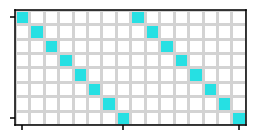

In [48]:
plt.figure(figsize=(3, 1.5))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#26e0e3'])
matrix = np.random.randint(0, 2, size=(10, 10))
N_EPG = 8
W_EPG_PFN = np.tile(np.eye(N_EPG), reps=(1, 2))  # (8, 16)

plt.pcolormesh(W_EPG_PFN, edgecolors='lightgray', linewidth=1, cmap=cmap)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.xticks([0.5, 7.5, 15.5])
plt.gca().set_xticklabels(["", "", ""])
plt.yticks([0.5, 7.5])
plt.gca().set_yticklabels(["", ""])
plt.show()

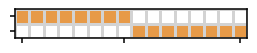

In [49]:
plt.figure(figsize=(3, 0.5))
W_LNO_PFN = np.array(
    [
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    ]
)  # (2, 16)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#e79a48'])
plt.pcolormesh(W_LNO_PFN, edgecolors='lightgray', linewidth=1, cmap=cmap)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.yticks([0.5, 1.5])
plt.gca().set_yticklabels(["", ""])
plt.xticks([0.5, 7.5, 15.5])
plt.gca().set_xticklabels("")
plt.show()

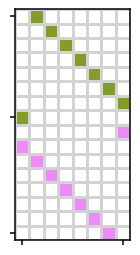

In [50]:
plt.figure(figsize=(1.5, 3))
W_PFNdl_HDELTA = np.roll(np.eye(8), 1, axis=1)  # (8, 8)
W_PFNdr_HDELTA = np.roll(np.eye(8), -1, axis=1) * 0.5 # (8, 8)
W_PFNd_HDELTA = np.vstack((W_PFNdl_HDELTA, W_PFNdr_HDELTA))  # (16, 8)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#ffffff', "#ec8bf8", '#829d2a'])
plt.pcolormesh(W_PFNd_HDELTA, edgecolors='lightgray', linewidth=1, cmap=cmap)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.yticks([0.5, 7.5, 15.5])
plt.gca().set_yticklabels(["", "", ""])
plt.xticks([0.5, 7.5])
plt.gca().set_xticklabels(["", ""])
plt.show()

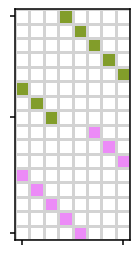

In [51]:
plt.figure(figsize=(1.5, 3))
W_PFNvl_HDELTA = np.roll(np.eye(8), 3, axis=1)  # (8, 8)
W_PFNvr_HDELTA = np.roll(np.eye(8), -3, axis=1) * 0.5  # (8, 8)
W_PFNv_HDELTA = np.vstack((W_PFNvl_HDELTA, W_PFNvr_HDELTA))  # (16, 8)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#ffffff', "#ec8bf8", '#829d2a'])
plt.pcolormesh(W_PFNv_HDELTA, edgecolors='lightgray', linewidth=1, cmap=cmap)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.yticks([0.5, 7.5, 15.5])
plt.gca().set_yticklabels(["", "", ""])
plt.xticks([0.5, 7.5])
plt.gca().set_xticklabels(["", ""])
plt.show()

### Wang data (Fig. S4E)

In [52]:
vt_df = pd.read_csv(f"{data_root / 'wang' / 'vT.txt'}")
vt_df["final_lvl_pos_x"] = vt_df.apply(lambda df: df["LVL"] * np.sin(np.radians(df["alpha"])), axis=1)
vt_df["final_lvl_pos_y"] = vt_df.apply(lambda df: df["LVL"] * np.cos(np.radians(df["alpha"])), axis=1)
print("Release sites:", vt_df["Rsite"].unique())
sub_df = vt_df[vt_df["Rsite"] == "HR"]
print("Num trials from regular home release:", sub_df.shape[0])
print("Num recruits:", len(sub_df["Bee"].unique()))
hr_to_feeder_bearing = 71 # Degrees
hr_to_feeder = 384 # meters
sub_df.head()

Release sites: ['HR' 'R1' 'R2' 'R5' 'R6' 'R7']
Num trials from regular home release: 62
Num recruits: 61


,Bee,alpha,LVL,AVL,Str,speed,De_Fr,De_Fv,Rsite,alphaRad,RsiteEW,RsiteNS,sTrow,final_lvl_pos_x,final_lvl_pos_y
0,g159,68.227534,235.213321,242.092639,0.971584,7.336141,162.515686,162.515686,HR,1.190795,0,0,1.0,218.434187,87.245702
1,r271,68.694838,359.995534,379.859127,0.947708,9.739978,39.220032,39.220032,HR,1.198951,0,0,2.0,335.392899,130.799035
2,y139,69.592051,196.957480,219.162687,0.898682,9.528812,200.328509,200.328509,HR,1.214610,0,0,NaN,184.595172,68.679483
3,y176,74.194609,276.884051,334.753229,0.827129,8.583416,121.959779,121.959779,HR,1.294940,0,0,3.0,266.415721,75.415127
4,y123,70.732013,195.974782,203.087728,0.964976,8.123509,201.096968,201.096968,HR,1.234507,0,0,4.0,184.997347,64.669133


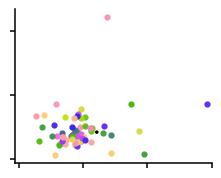

In [53]:
plt.figure(figsize=(3, 2))
consistent_colours = []
for i, (index, row) in enumerate(sub_df.iterrows()):
    color = cmap(np.random.uniform(0, 1))
    consistent_colours.append(color)
    plt.scatter(row["final_lvl_pos_x"], row["final_lvl_pos_y"], color=color, s=12)
    
plt.ylabel("")
plt.xlabel("")
plt.ylim(-20, 700)
plt.xlim(-20, 900)
ax = plt.gca()
ax.set_yticks([0, 300, 600])
ax.set_xticks([0, 300, 600, 900])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_aspect('equal')
x = hr_to_feeder * np.sin(np.radians(hr_to_feeder_bearing))
y = hr_to_feeder * np.cos(np.radians(hr_to_feeder_bearing))
feeder = plt.Circle((x, y), 5, color='black', label="Feeder")
ax.add_patch(feeder)  # Nest is at (0,0)
plt.show()

914.774660831836


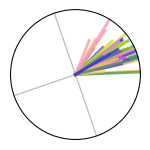

In [54]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(1.7,1.7))
max_frame = 0
alpha = 0.8
for i, (index, row) in enumerate(sub_df.iterrows()):
    final_angle_error = np.radians(row["alpha"])
    final_frame = row["LVL"]
    max_frame = max(max_frame, final_frame)
    ax.plot([0.0, final_angle_error], [0, final_frame], color=consistent_colours[i], linewidth=2, alpha=alpha)
print(max_frame)
max_frame = hr_to_feeder
ax.set_ylim(0, max_frame)
ax.set_yticklabels("")
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_theta_direction(-1)
lw = 0.9
circle = plt.Circle((0.0, 0.0), max_frame, transform=ax.transData._b, fill=False, linewidth=1.5, zorder=2)
ax.add_artist(circle)
ax.axvline(np.radians(hr_to_feeder_bearing), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=1)
ax.axvline(np.radians(hr_to_feeder_bearing) + np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=1)
ax.axvline(np.radians(hr_to_feeder_bearing) + np.radians(90) , 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=1)
ax.axvline(np.radians(hr_to_feeder_bearing) + np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=1)
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(180)
ax.set_thetagrids([], fontsize=11)
ax.spines['polar'].set_visible(False)

914.774660831836


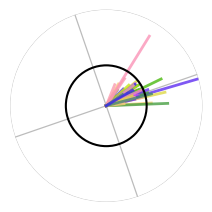

In [55]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(2.5, 2.5))
max_frame = 0
alpha = 0.8
for i, (index, row) in enumerate(sub_df.iterrows()):
    final_angle_error = np.radians(row["alpha"])
    final_frame = row["LVL"]
    max_frame = max(max_frame, final_frame)
    ax.plot([0.0, final_angle_error], [0, final_frame], color=consistent_colours[i], linewidth=2, alpha=alpha)

print(max_frame)
ax.set_ylim(0, max_frame)
circle = plt.Circle((0.0, 0.0), max_frame, transform=ax.transData._b, fill=False, linewidth=0.5, zorder=2, color="#BCBCBC")
ax.add_artist(circle)
max_frame = hr_to_feeder
ax.set_theta_direction(-1) 
ax.set_yticklabels("")
ax.set_yticks([])
ax.set_yticklabels([])
lw = 0.9
circle = plt.Circle((0.0, 0.0), max_frame, transform=ax.transData._b, fill=False, linewidth=1.5, zorder=2)
ax.add_artist(circle)
ax.axvline(np.radians(hr_to_feeder_bearing), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=1)
ax.axvline(np.radians(hr_to_feeder_bearing) + np.radians(180), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=1)
ax.axvline(np.radians(hr_to_feeder_bearing) + np.radians(90) , 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=1)
ax.axvline(np.radians(hr_to_feeder_bearing) + np.radians(-90), 0, 180, color="#BCBCBC", linewidth=lw, zorder=-1, alpha=1)
ax.set_theta_zero_location("N")
ax.set_thetamin(-180)
ax.set_thetamax(180)
ax.set_thetagrids([], fontsize=11)
ax.spines['polar'].set_visible(False)
# Rotate to centre grey axis (centred on feeder)

/var/folders/zk/_6v92pbn1jb2gnrh76qkpng1y98vd4/T/ipykernel_13621/3683433562.py:13: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(data=plot_df, x="dataset", y="abs_deg", width=0.65, showfliers=True, palette=["white", "#E0E0E0"], **BXPLT_PROPS)
/var/folders/zk/_6v92pbn1jb2gnrh76qkpng1y98vd4/T/ipykernel_13621/3683433562.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
/var/folders/zk/_6v92pbn1jb2gnrh76qkpng1y98vd4/T/ipykernel_13621/3683433562.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Wang_AllRS", "Wang_HR", "Ours"])


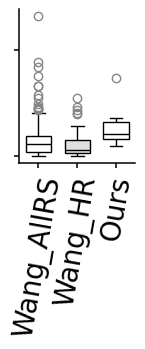

In [56]:
def adjust_alpha(alpha):
    return np.where(alpha > hr_to_feeder_bearing, alpha - hr_to_feeder_bearing, hr_to_feeder_bearing - alpha)

sub_df["abs_deg"] = adjust_alpha(sub_df["alpha"])
sub_df["dataset"] = "Wang"
vt_df["abs_deg"] = adjust_alpha(vt_df["alpha"])
vt_df["dataset"] = "WangAll"
own_data = pd.read_csv(f"{data_root / experiment_run_date}-foodward_error_vector_averaging_midpt.csv")
own_data["dataset"] = "Ours"
plot_df = pd.concat([vt_df, sub_df, own_data])

plt.figure(figsize=(1.5, 2.0))
ax = sns.boxplot(data=plot_df, x="dataset", y="abs_deg", width=0.65, showfliers=True, palette=["white", "#E0E0E0"], **BXPLT_PROPS)
ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
ax.set_yticks([0, 90])
ax.set_yticklabels(["", ""])
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels(["Wang_AllRS", "Wang_HR", "Ours"])
plt.legend([],[], frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)